1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.


 2*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

3*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [2029]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn import datasets

In [2030]:
# Отображение таблиц полостью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2031]:
# глобальные константы
N_SAMPLES = 1000
N_FEATCHES = 2
N_CLASSES = 2
# N_TREES = [1, 3, 10, 50, 100, 200]
N_TREES = [1, 3, 10]
QUALITY_TYPES = {0: 'Неопределенность Джини',
                 1: 'Энтропия Шеннона',
                 2: 'Ошибка классификации',
                 3: 'Дисперсия (регрессия)'}


In [2032]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( \
    n_samples = N_SAMPLES, n_features = N_FEATCHES, n_informative = N_FEATCHES, \
    n_classes = N_CLASSES, n_redundant=0, n_clusters_per_class=1, random_state=13)

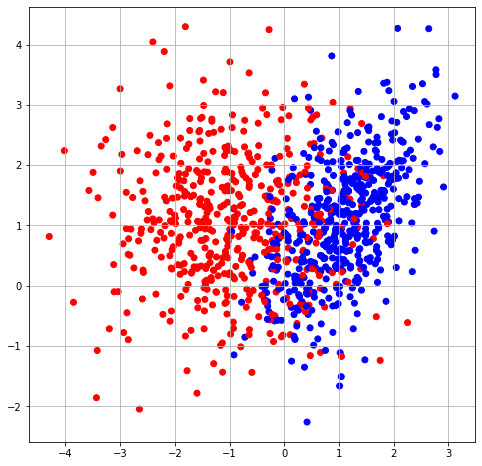

In [2033]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), \
            list(map(lambda x: x[1], classification_data)), \
            c=classification_labels, cmap=colors)
plt.grid(True)

In [2034]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [2035]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        



---



In [2036]:
random.seed(42)

def get_bootstrap(data, labels, n_subsamples):
    # функция для генерации подвыборок с помощью бутстрэпа
    # в отличие от предыдущей версии get_bootstrap0, где labels[indices].astype(np.float64)
    # здесь labels[indices].astype(np.int64), что дает прирост скорости выполнения
    # метода random_forest на n_trees=5 ~ 55 сек против ~ 2 мин 15 сек (get_bootstrap0)
    n_samples = data.shape[0]
    n_featches = data.shape[1]
    indices = np.random.randint(0, len(data), (n_subsamples, len(data)))
    bootstrap = list(map(lambda a, b: (a.reshape(n_samples, n_featches), b.flatten()), \
                      np.split(data[indices], n_subsamples), \
                      np.split(labels[indices], n_subsamples)))
    return bootstrap

In [2037]:
# Сохранение случайных индексов подвыборки
random.seed(42)

def get_subsample_indices(len_sample):

    subsample_indices = set()
    len_subsample = int(np.sqrt(len_sample))
    while len(subsample_indices) < len_subsample:
        subsample_indices.add(random.randint(0, len_sample - 1))

    return list(subsample_indices)

In [2038]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [2039]:
# Расчет критерия энтропии Шеннона 

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    for label in classes:
        p = classes[label] / len(labels)
        entropy = - (p * np.log2(p))
        
    return entropy

In [2040]:
# Расчет критерия ошибки классификации (misclassification error) 

def missclass(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    missclass_err = 1 - max(P)
        
    return missclass_err

In [2041]:
# Расчет критерия для регрессии - дисперсия
# РАБОТАЕТ НЕ ВЕРНО!!!!

def var(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    P = []
    for label in classes:
        p = classes[label] / len(labels)
        P.append(p)
    var = np.array(P).var()

    return var

In [2042]:
# УДАЛИТЬ ЯЧЕЙКУ!!!
# Расчет качества

def _quality(left_labels, right_labels, current_gini, type_quality = 0):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [2043]:
# Расчет качества

def quality(left_labels, right_labels, prev_quality, type_quality = 0):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    if type_quality == 0:
        return prev_quality - p * gini(left_labels) - (1 - p) * gini(right_labels)
    elif type_quality == 1:
        return prev_quality - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    elif type_quality == 2:
        return prev_quality - p * missclass(left_labels) - (1 - p) * missclass(right_labels)
    else:# РАБОТАЕТ НЕ ВЕРНО!!!!
        return prev_quality - p * var(left_labels) - (1 - p) * var(right_labels)

In [2044]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [2045]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, type_quality = 0):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    if type_quality == 0:
        prev_quality = gini(labels)
    elif type_quality == 1:
        prev_quality = entropy(labels)
    elif type_quality == 2:
        prev_quality = missclass(labels)
    else:
        prev_quality = var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample_indices = get_subsample_indices(n_features)
    
    for index in subsample_indices:

        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, prev_quality, type_quality)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [2046]:
# Построение дерева с помощью рекурсивной функции
# Критерии останова: количество листьев, количество используемых признаков, глубина дерева

def build_tree(data, labels, type_quality = 0, tree_level = 1, max_tree_level = 20000, max_leaf_count = 50000):

    global leaf_count
    # print('data:', data)
    # print('labels:', labels)

    quality, t, index = find_best_split(data, labels, type_quality)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества,
    #  Или когда уровень вложенности равен максимальному,
    #  Или когда общее количество листов больше или равно максимальному
    if quality == 0 or tree_level == max_tree_level or leaf_count >= max_leaf_count:
        leaf_count += 1
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    tree_level += 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, type_quality, tree_level)
    false_branch = build_tree(false_data, false_labels, type_quality, tree_level)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [2047]:
def random_forest(data, labels, n_trees, type_quality):
    
    # Получение бутстрапа - случайных подвыборок labels
    bootstrap = get_bootstrap(data, labels, n_trees) # новая версия с labels[indices].astype(np.int64)
    
    forest = [build_tree(b_data, b_labels, type_quality) for b_data, b_labels in bootstrap]
        
    return forest

In [2048]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [2049]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = [classify_object(obj, tree) for obj in data]
    return classes

In [2050]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = [predict(data, tree) for tree in forest]

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
        
    return voted_predictions


50 trees
---



In [2051]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [2052]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees, 0)

In [2053]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [2054]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [2055]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [2056]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 85.333



50 trees
---



In [2057]:
# # УДАЛИТЬ ЯЧЕЙКУ!!!
# %%time
# train_answers = tree_vote(rf, train_data)

In [2058]:
# Метод получения метрик качества
# Нужен подключенный Numpy as np: import numpy as np
def quality_metrics(y_true, y_predict, get_metrics = '*', bin_threshold = 0.5):
    # get_metrics = '*' - получение всех метрик: accuracy, matrix_errors, precision, recall, F_score
    # get_metrics = 'a'/'accuracy' - получение accuracy
    # get_metrics = 'm'/'matrix_errors' - получение matrix_errors
    # get_metrics = 'p'/'precision' - получение precision
    # get_metrics = 'r'/'recall' - получение recall
    # get_metrics = 'f'/'f_score' - получение f_score
    # get_metrics = 'tp' - получение TP
    # get_metrics = 'tn' - получение TN
    # get_metrics = 'fn' - получение FN
    # get_metrics = 'fp' - получение FP

    metrics = {}
    y = np.array(y_true)
    y_pred = np.array(y_predict)

    TP = ((y > bin_threshold) & (y_pred > bin_threshold)).sum()
    TN = ((y <= bin_threshold) & (y_pred <= bin_threshold)).sum()
    FN = ((y > bin_threshold) & (y_pred <= bin_threshold)).sum()
    FP = ((y <= bin_threshold) & (y_pred > bin_threshold)).sum()

    # accuracy - доля правильных ответов
    accuracy = (TP + TN) / y.shape[0]

    # матрица ошибок
    matrix_errors = np.array([[TP, FP],[FN, TN]])

    # precision
    precision = TP / (TP + FP)

    # recall
    recall = TP / (TP + FN)

    # recall
    f_score =  2 * precision * recall / (precision + recall)

    for m in get_metrics.split(','):
        m = m.strip()
        if m == '*':
            metrics['accuracy'] = accuracy
            metrics['matrix_errors'] = matrix_errors
            metrics['precision'] = precision
            metrics['recall'] = recall
            metrics['f_score'] = f_score
            break
        elif m == 'a' or m == 'accuracy':
            metrics['accuracy'] = accuracy
        elif m == 'm' or m == 'matrix_errors':
            metrics['matrix_errors'] = matrix_errors
        elif m == 'p' or m == 'precision':
            metrics['precision'] = precision
        elif m == 'r' or m == 'recall':
            metrics['recall'] = recall
        elif m == 'f' or m == 'f_score':
            metrics['f_score'] = f_score
        elif m == 'tp':
            metrics['TP'] = TP
        elif m == 'tn':
            metrics['TN'] = TN
        elif m == 'fn':
            metrics['FN'] = FN
        elif m == 'fp':
            metrics['FP'] = FP

    return metrics

In [2059]:
# Распечатка метрик качества разбиения
def print_metrics(labels, data, n_trees, type_sample, type_quality):
    metrics = quality_metrics(labels, data)

    if type_sample == 0:
        print(f"\nМетрики качества случайного леса из {n_trees} деревьев на обучающей выборке")
    else:
        print(f"\nnМетрики качества случайного леса из {n_trees} деревьев на тестовой выборке")
    if type_quality == 0:
        print("с критерием качества разбиения неопределенности Джини:")
    elif type_quality == 1:
        print("с критерием качества разбиения энтропией Шеннона:")
    elif type_quality == 2:
        print("с критерием качества разбиения ошибкой классификации:")
    else:
        print("с критерием качества разбиения дисперсией (для регрессии):")
    print(f"accuracy={metrics['accuracy']:.3f}")
    print(f"matrix_errors:\n{metrics['matrix_errors']}")
    print(f"precision={metrics['precision']:.3f}")
    print(f"recall={metrics['recall']:.3f}")
    print(f"F_score={metrics['f_score']:.3f}")

In [2060]:
# Накопление метрик качества разбиения
def get_metrics(labels, data, n_trees, type_sample, type_quality):
    metrics = quality_metrics(labels, data)
    metrics[f'accuracy_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('accuracy', '-')
    metrics[f'matrix_errors_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('matrix_errors', '-')
    metrics[f'precision_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('precision', '-')
    metrics[f'recall_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('recall', '-')
    metrics[f'f_score_{n_trees}_{type_sample}_{type_quality}'] = metrics.pop('f_score', '-')
    return metrics



---





Начало работы



In [2061]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = \
    model_selection.train_test_split(classification_data, \
                                     classification_labels, \
                                     test_size = 0.3, \
                                     random_state = 1)

In [2062]:
# Построим случайные леса из {N_TREES} деревьев по обучающей и тестовой выборкам
# с различными критериями качества разбиения

# Результаты работы
data_table = []

for n_trees in N_TREES:

    for type_quality in range(3):

        # Текущее значение общего количества листов
        leaf_count = 0

        # Построим случайный лес из {n_trees} деревьев и {type_quality} критерием качества разбиения
        my_forest = random_forest(train_data, train_labels, n_trees, type_quality)

        # Получим ответы для обучающей выборки 
        train_answers = tree_vote(my_forest, train_data)

        # И получим ответы для тестовой выборки
        test_answers = tree_vote(my_forest, test_data)

        # Накопление результатов

        for metric in ['accuracy', 'matrix_errors', 'precision', 'recall', 'f_score']:
            for type_sample in range(2):

                if type_sample == 0:
                    name_sample = 'обучающая'
                    # Точность на обучающей выборке
                    metrics = get_metrics(train_labels, train_answers, n_trees, type_sample, type_quality)
                else:
                    name_sample = 'тестовая'
                    # Точность на тестовой выборке
                    metrics = get_metrics(test_labels, test_answers, n_trees, type_sample, type_quality)

                data_table.append([n_trees, name_sample, QUALITY_TYPES[type_quality], metric, metrics[f'{metric}_{n_trees}_{type_sample}_{type_quality}']])


# Вывод результатов в табличном виде
data_table.sort(key=lambda i: i[3])
head_table = ['Кол-во деревьев', 'Выборка', 'Критерий качества разбиения', 'Метрика качества', 'Значение']
pd.DataFrame(data_table, columns=head_table)

,Кол-во деревьев,Выборка,Критерий качества разбиения,Метрика качества,Значение
0,1,обучающая,Неопределенность Джини,accuracy,0.92
1,1,тестовая,Неопределенность Джини,accuracy,0.776667
2,1,обучающая,Энтропия Шеннона,accuracy,0.922857
3,1,тестовая,Энтропия Шеннона,accuracy,0.843333
4,1,обучающая,Ошибка классификации,accuracy,0.841429
5,1,тестовая,Ошибка классификации,accuracy,0.886667
6,3,обучающая,Неопределенность Джини,accuracy,0.958571
7,3,тестовая,Неопределенность Джини,accuracy,0.833333
8,3,обучающая,Энтропия Шеннона,accuracy,0.955714
9,3,тестовая,Энтропия Шеннона,accuracy,0.806667


In [2124]:
acc00 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'обучающая' and \
    x[2] == 'Неопределенность Джини' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]
acc10 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'тестовая' and \
    x[2] == 'Неопределенность Джини' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]
acc01 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'обучающая' and \
    x[2] == 'Энтропия Шеннона' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]
acc11 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'тестовая' and \
    x[2] == 'Энтропия Шеннона' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]
acc02 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'обучающая' and \
    x[2] == 'Ошибка классификации' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]
acc12 = [y for y in list(map(lambda x: x[-1] if \
    (x[1] == 'тестовая' and \
    x[2] == 'Ошибка классификации' and \
    x[3] == 'accuracy') else None, data_table)) \
    if y is not None]


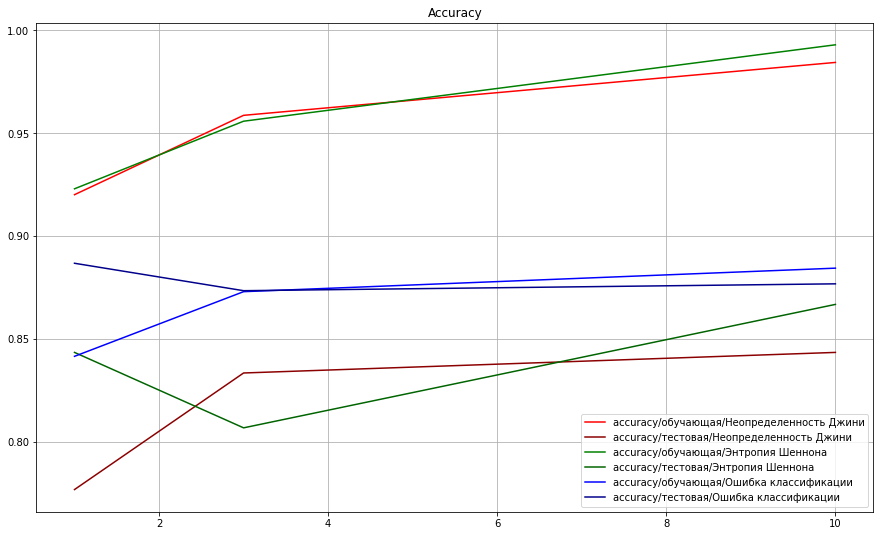

In [2125]:
# Построение графиков

plt.figure(figsize=(15, 9))
plt.title('Accuracy')
plt.plot(N_TREES, acc00, c='red', label='accuracy/обучающая/Неопределенность Джини')
plt.plot(N_TREES, acc10, c='darkred', label='accuracy/тестовая/Неопределенность Джини')
plt.plot(N_TREES, acc01, c='green', label='accuracy/обучающая/Энтропия Шеннона')
plt.plot(N_TREES, acc11, c='darkgreen', label='accuracy/тестовая/Энтропия Шеннона')
plt.plot(N_TREES, acc02, c='blue', label='accuracy/обучающая/Ошибка классификации')
plt.plot(N_TREES, acc12, c='darkblue', label='accuracy/тестовая/Ошибка классификации')
plt.grid(True)
plt.legend(loc='best')

In [2126]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

IndexError: ignored

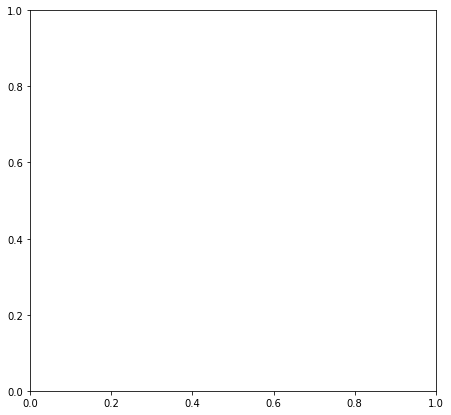

In [2127]:
# Визуализируем дерево на графике с критерием качества разбиения неопределенности Джини

plt.figure(figsize = (16, 7))

# график обучающей выборки с критерием качества разбиения неопределенности Джини
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_forest)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f"Gini impurity. Train accuracy={train_metrics0['accuracy']:.2f}")

# график тестовой выборки с критерием качества разбиения неопределенности Джини
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f"Gini impurity. Test accuracy={metrics0['accuracy']:.2f}")